In [1]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/MyDrive/COLAB')
sys.path.append(str(base))

Mounted at /content/drive


In [2]:
#here base = Path('/content/drive/MyDrive/COLAB')

zip_path =  base/'Mask_Detection/mask_dataset_archive.zip'
!cp "{zip_path}" .
!unzip -q mask_dataset_archive.zip
!rm mask_dataset_archive.zip


#zip_path. If you’ve followed this tutorial for setting up your Colab environment, you have access to the path to the top level of Drive via base. From there you need to specify the exact path to the zip file that contains your training data.
# The next line copies the file in zip_path to the current working directory (indicated by the dot)
# Unzip… well unzips the archive. Instead of cats_dogs.zip, enter whatever name your archive has. The option -q makes this a quiet operation. Otherwise, it would print the name of every file that is unzipped to your Colab, which you probably don’t want.
# The last line removes the archive. Since you have unzipped its content anyway, you don’t need it in Colab anymore.

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import os

In [5]:
os.chdir('/content/Face_Mask_Dataset')
dataset = 'Train'
data_dir = os.listdir(dataset)
print(data_dir)


['WithMask', 'WithoutMask']


In [22]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

img_rows, img_columns = 115, 115

images = []
labels = []

for category in data_dir:
  folder_path = os.path.join(dataset, category)
  for img in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img)
    img = cv2.imread(img_path)

    try:
      gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      resized_image = cv2.resize(gray_image, (img_rows, img_columns))
      images.append(resized_image)
      labels.append(category)
    except Exception as e:
      print("Exception Found: ", e)

images = np.array(images)/255.0
images = np.reshape(images, (images.shape[0], img_rows, img_columns, 1))

#Explanation for above lines
# The Convolution2D layers in Keras however, are designed to work with 3 
# dimensions per example. They have 4-dimensional inputs and outputs. 
# This covers colour images (nb_samples, nb_channels, width, height), 
# but more importantly, it covers deeper layers of the network, 
# where each example has become a set of feature maps
# i.e. (nb_samples, nb_features, width, height).

# The greyscale image for MNIST digits input would either need a different
# CNN layer design (or a param to the layer constructor to accept a different shape),
# or the design could simply use a standard CNN and you must explicitly express the 
# examples as 1-channel images. The Keras team chose the latter approach,
# which needs the re-shape.

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
#np_utils.to_categorical is used to convert array of 
#labeled data(from 0 to nb_classes - 1) to one-hot vector.
labels = np.array(labels)

(train_X, test_X, train_y, test_y) = train_test_split(images, labels, test_size=0.25, random_state = 0)


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D

num_classes = 2
batch_size = 32

model = Sequential()


#first Convolution layer
model.add(Conv2D(64, (3,3), input_shape = (img_rows, img_columns, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#second Convolution Layer
model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
# In every layer filters are there to capture patterns. For example in 
# the first layer filters capture patterns like edges, corners, dots etc. 
# In the subsequent layers we combine those patterns to make bigger patterns. 
# Like combine edges to make squares, circle etc.
# Now as we move forward in the layers the patterns gets more complex, 
# hence larger combinations of patterns to capture. That's why we increase 
# filter size in the subsequent layers to capture as many combinations as possible.

model.add(Flatten())
model.add(Dropout(0.5))

#Adding fully connected layer
model.add(Dense(64, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))


In [24]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 113, 113, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 54, 54, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 93312)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [25]:
from keras.optimizers import Adam

epochs = 50

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.0001), metrics = ['accuracy'])

fitted_model = model.fit(train_X, train_y, epochs = epochs, validation_split = 0.25)

Epoch 1/50
176/176 [==============================] - 3s 17ms/step - loss: 0.4201 - accuracy: 0.8069 - val_loss: 0.1726 - val_accuracy: 0.9429
Epoch 2/50
176/176 [==============================] - 3s 16ms/step - loss: 0.1535 - accuracy: 0.9447 - val_loss: 0.1522 - val_accuracy: 0.9451
Epoch 3/50
176/176 [==============================] - 3s 16ms/step - loss: 0.1117 - accuracy: 0.9611 - val_loss: 0.1620 - val_accuracy: 0.9435
Epoch 4/50
176/176 [==============================] - 3s 16ms/step - loss: 0.0974 - accuracy: 0.9653 - val_loss: 0.1055 - val_accuracy: 0.9595
Epoch 5/50
176/176 [==============================] - 3s 16ms/step - loss: 0.0793 - accuracy: 0.9708 - val_loss: 0.1395 - val_accuracy: 0.9525
Epoch 6/50
176/176 [==============================] - 3s 16ms/step - loss: 0.0731 - accuracy: 0.9730 - val_loss: 0.0884 - val_accuracy: 0.9643
Epoch 7/50
176/176 [==============================] - 3s 16ms/step - loss: 0.0619 - accuracy: 0.9783 - val_loss: 0.0852 - val_accuracy: 0.9659

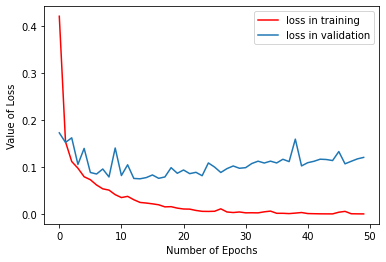

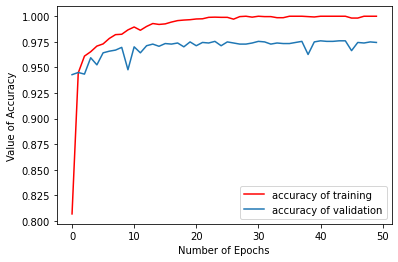

In [26]:
from matplotlib import pyplot as plt

#Training V/s Validation Loss
plt.plot(fitted_model.history['loss'], 'r', label = 'loss in training')
plt.plot(fitted_model.history['val_loss'], label = 'loss in validation')
plt.xlabel('Number of Epochs')
plt.ylabel('Value of Loss')
plt.legend()
plt.show()

#Training V/s Validation Accuracy
plt.plot(fitted_model.history['accuracy'], 'r', label = 'accuracy of training')
plt.plot(fitted_model.history['val_accuracy'], label = 'accuracy of validation')
plt.xlabel('Number of Epochs')
plt.ylabel('Value of Accuracy')
plt.legend()
plt.show()

In [29]:
model.save('/content/drive/MyDrive/COLAB/Mask_Detection/face_mask_detector_model.h5')